# Burger equation in 1D: joint estimation (vanilla)

Consider the following PDE:
$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \nu \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), \text{ (temporal boundary condition)}\\
u(t,-1)=u(t,1)=0, \text{ (boundary condition)}
\end{cases}
$$

This has been studied in [this article](https://www.mdpi.com/2073-4441/13/4/423) for example.

In this notebook we jointly estimate the equation solution with a PINN and the equation parameter $\nu$. To do so we follow the methodology straightforward methodology from _Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations_, Raissi et al., 2019, i.e., we minimize the dynamic loss with respect to both the neural network parameters and the equation parameters. We also make use of a batch of available observations. See more explanation at [this page](https://hgangloff.pages.mia.inra.fr/pinn_experiments/param_estim_pinn.html)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [3]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [4]:
import jinns

/home/hugo/anaconda3/envs/pinn2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import other dependencies

In [5]:
import jax
import numpy as np
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

## Observations

We use artificial observations from the estimated solution from the other notebook on Burger equation.

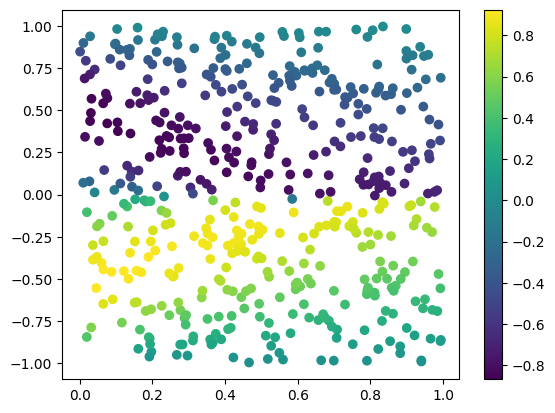

In [6]:
observations = jnp.load("burger_solution_grid.npy")
key, subkey = jax.random.split(key)
size_subsample = 500
time_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[0], 1),
    shape=(size_subsample,),
    replace=False
)
key, subkey = jax.random.split(key)
size_subsample = 500
omega_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[1], 1),
    shape=(size_subsample,),
    replace=False
)
obs_batch = observations[
    time_subsample,
    omega_subsample
]

plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()

__Optionally blur the observed values__

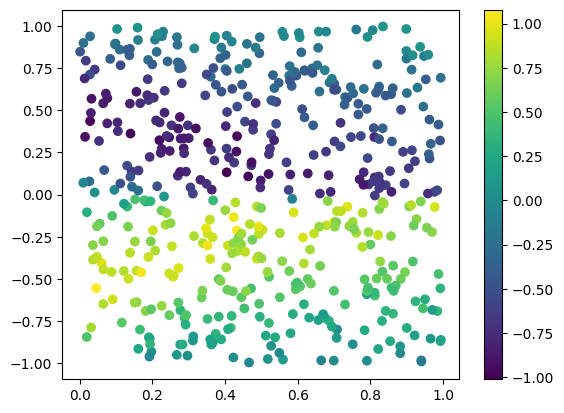

In [7]:
obs_batch_ori = obs_batch.copy()
key, subkey = jax.random.split(key)
obs_batch = obs_batch.at[:, 2].set(
    obs_batch[:, 2] +
    random.normal(subkey, obs_batch[:, 2].shape) * 0.1
)


plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [8]:
class MLP(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4 = random.split(key, 4)

        self.layers = [
            eqx.nn.Linear(2, 20, key=key1),
            jax.nn.tanh,
            eqx.nn.Linear(20, 20, key=key2),
            jax.nn.tanh,
            eqx.nn.Linear(20, 20, key=key3),
            jax.nn.tanh,
            eqx.nn.Linear(20, 1, key=key4),
        ]
    def __call__(self, t):
        for layer in self.layers:
            t = layer(t)
        return t

def make_mlp(key):
    mlp = MLP(key) 
    params, static = eqx.partition(mlp, eqx.is_inexact_array)

    def init_fn():
        return params

    def apply_fn(t, x, u_params, eq_params=None): # NOTE here the unused eq_params
        model = eqx.combine(u_params, static)
        t_x = jnp.concatenate([t, x], axis=-1)
        return model(t_x)[0]

    return init_fn, apply_fn

In [9]:
init_param_fn, u = make_mlp(subkey)
init_nn_params = init_param_fn()

Create a DataGenerator object

In [10]:
n = 1000
nt = 1000
nb = 2
omega_batch_size = 32
temporal_batch_size = 20
omega_border_batch_size = 1
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)

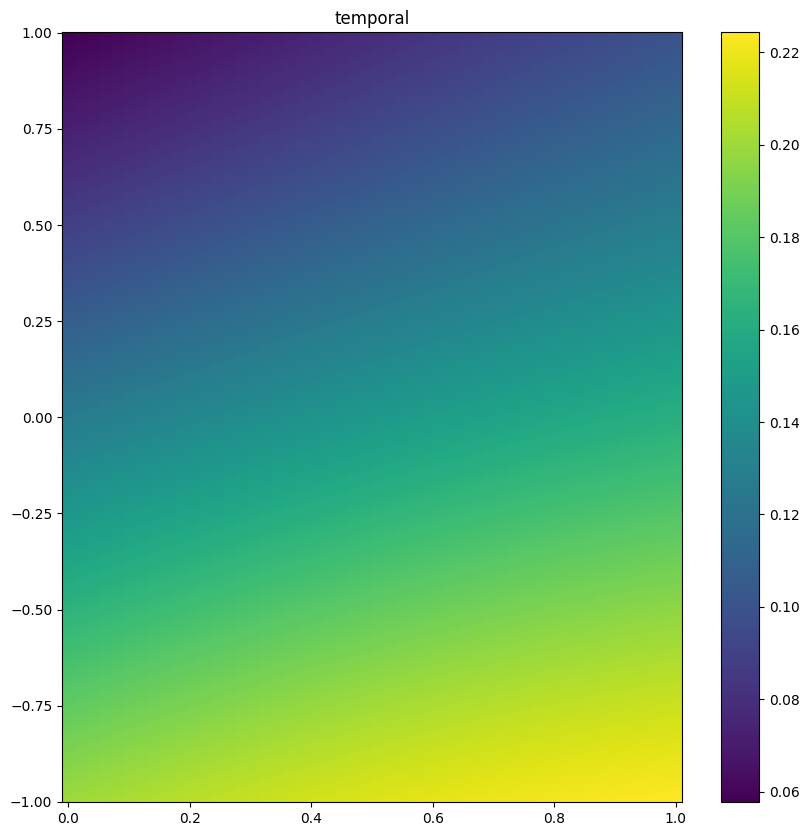

In [11]:
u_init = partial(u, u_params=init_nn_params)

Tmax = 1
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)

jinns.data.plot1d_image(u_init, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(10,10), title="temporal")

## Model parameters

__Optionally blur the initial parameter value__

In [12]:
# True is : nu = 1 / (100 * jnp.pi)
key, subkey = jax.random.split(key)
nu_ori = 1 / (100 * jnp.pi)
print(nu_ori)
nu = nu_ori + random.normal(subkey, shape=(1,)) * 0.001
print(nu)

0.0031830988618379067
[0.00302765]


A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [13]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "nu":nu
    }
}

## Initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

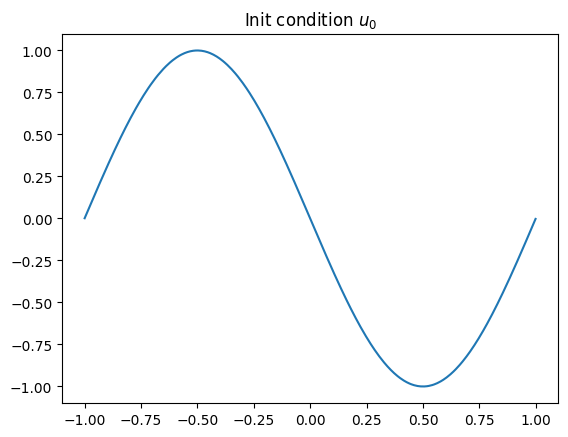

In [14]:
def u0(x):
    return -jnp.sin(jnp.pi * x)

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Loss construction

__Note: An important thing to note in the next cell is the derivative argument set to "both". This means that we will differentiate the Dynamic Loss both with respect to nn_params and eq_params.__

In [15]:
be_loss = jinns.loss.BurgerEquation(Tmax=Tmax, derivatives="both")

In [16]:
loss_weights = {"dyn_loss":1, "temporal_loss":1, "boundary_loss":1, "observations":1}
    
loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    omega_boundary_fun=lambda dx: 0,
    omega_boundary_condition="dirichlet",
    temporal_boundary_fun=u0,
    obs_batch=[obs_batch[:, 0], obs_batch[:, 1], obs_batch[:, 2]]
)

In [17]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 0.90
Individual losses: {'boundary_loss': '0.05', 'dyn_loss': '0.00', 'norm_loss': '0.00', 'observations': '0.34', 'temporal_loss': '0.51'}


## Joint estimation of `eq_params` and `nn_params`

In [18]:
params = init_params

In [19]:
# Optimizer
import optax
from jaxopt import OptaxSolver

In [20]:
n_iter = int(50000)

Here we alternate between optimizing `nn_params` and `eq_params` by using "opposite schedulers" in `optax`. We provide a utility function `alternate_optax_solver` which performs the alternating optimization.

In [21]:
# steps at which learning alternates between the two sets of params (excluding step 0 !)
steps = np.arange(1000, n_iter, 1000) # NOTE this is a numpy array !
tx = jinns.utils.alternate_optax_solver(steps, ["nn_params"], ["nu"], 1e-3, 1e-5)

Next consists in classical initializations

In [22]:
solver = OptaxSolver(opt=tx, fun=loss,
                     has_aux=True, # because the objective has aux output
                     maxiter=500000)

pinn_solver = jinns.solver.PinnSolver(
    optax_solver=solver,
    loss=loss,
    n_iter=n_iter
)

Next we define which parameter we want to track

In [23]:
accu_vars = [
    ['eq_params', 'nu']
]

Then optimization starts

In [24]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, train_data, loss, _, accu_vars_params = pinn_solver.solve(
    init_params=params,
    data=train_data,
    accu_vars=accu_vars
)

Running for 50,000 iterations: 100%|████████████████| 50000/50000 [01:18<00:00, 635.54it/s]


## Results

Plot the tracked parameters

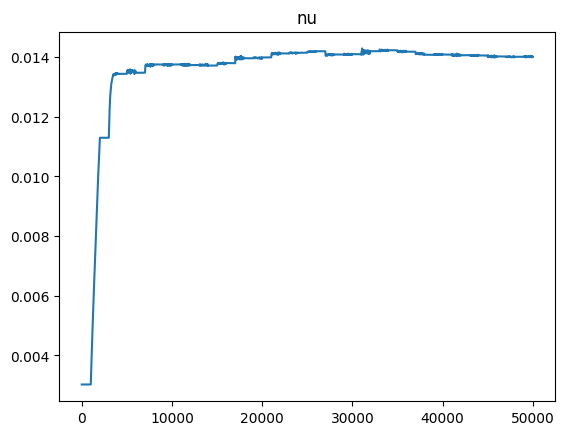

In [25]:
accu_vars_params
colors = ['blue']
plt.plot(accu_vars_params['-'.join(map(str, accu_vars[0]))])
plt.title(f"nu")
plt.show()

Plot the loss values

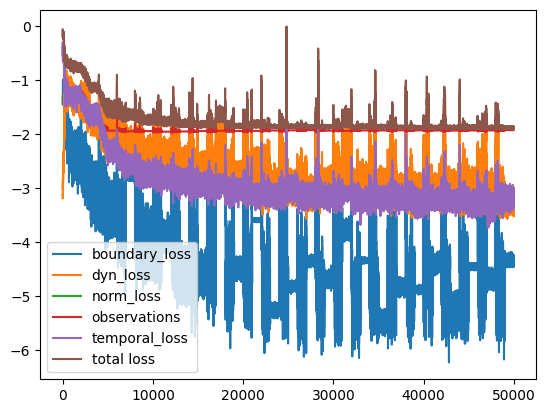

In [26]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the PDE solutions learned by the PINN

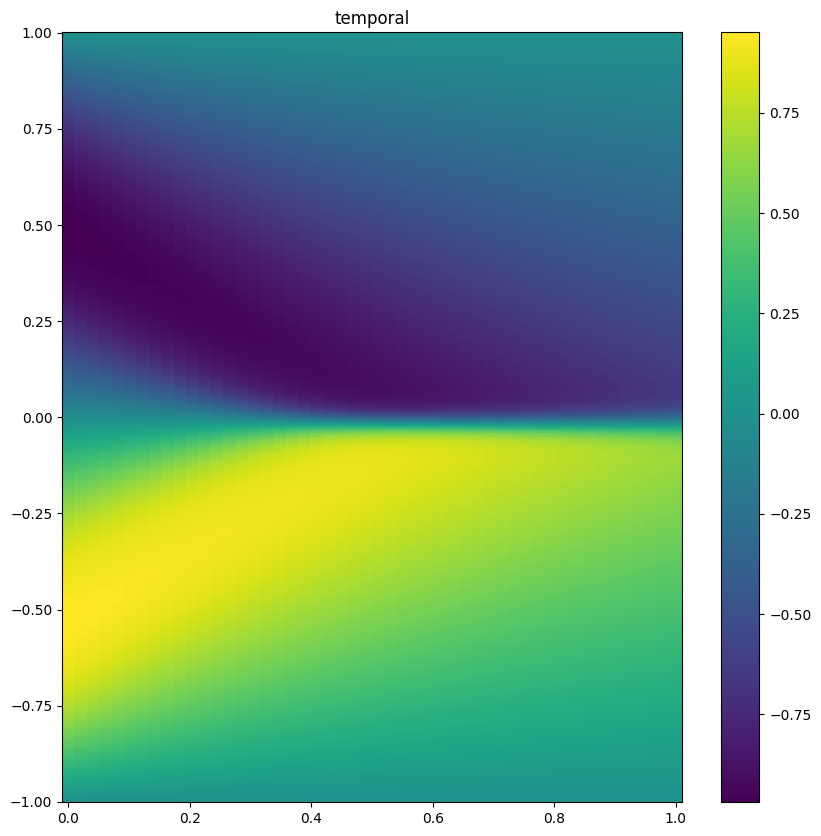

In [27]:
u_est = partial(u, u_params=params["nn_params"])

jinns.data.plot1d_image(u_est, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(10,10), title="u(t,x)")

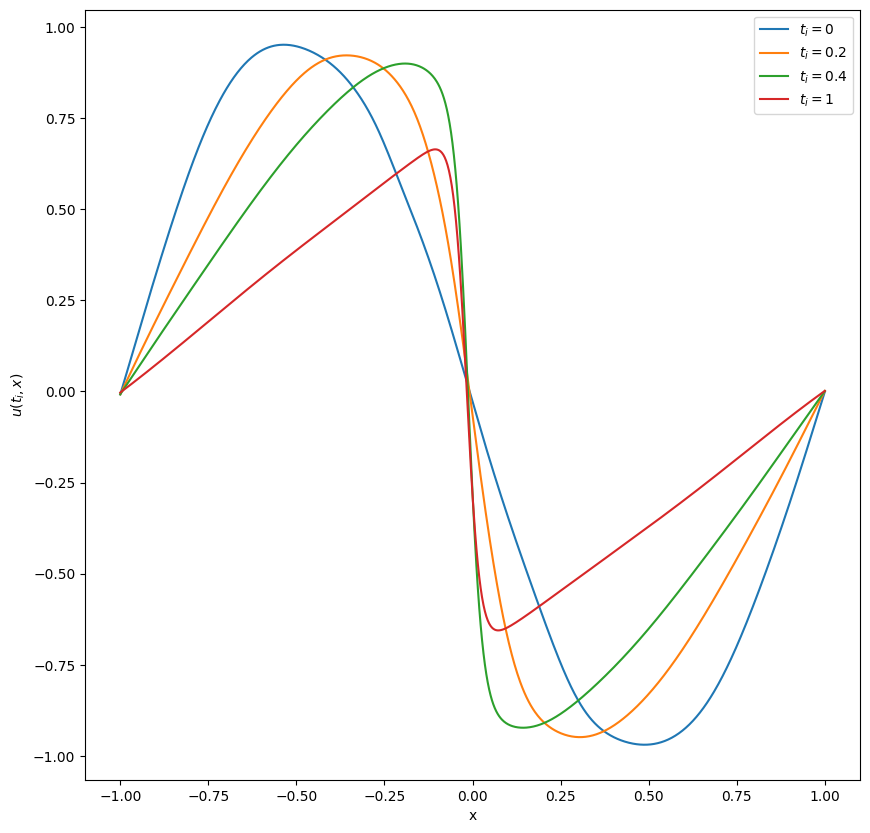

In [28]:
time_slices = [0, 0.2, 0.4, 1]
jinns.data.plot1d_slice(u_est, xdata=val_xdata, time_slices=time_slices)